# MRP : Implementing Pre-retrival Methods

In [1]:
#Importing Libraries 
import numpy as np
import os
from random import shuffle
import re
import urllib.request
import zipfile
import lxml.etree
#import wordcloud
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import math
import numpy
import string
from  nltk.tokenize  import word_tokenize
import datetime

### Reading TREC's ROBUST data collection 

In [2]:
# Set the Root file path - Path need to be changed
RootFilePath="C:/NareshPersonal/Python/MRP/cw09/"

#1.Loading all the collection documents 
#'test' is collections document folder name (might need to be changed) inside RootFilePath 
data_folder = os.path.join(RootFilePath, 'cw09')  

#2.Loading all the Queries 
#df2=pd.read_csv(RootFilePath+"cw12_web2013.topics.txt",delimiter=":",names=['QueryNo','Query'])

#3.Loading MAP results for comparision later 
#dfmap=pd.read_csv(RootFilePath+"cw09_mapresults/ClueWeb09_qmaporder.txt",delimiter=' ',names=['QueryNo','MAP'])

In [51]:
#Concatinating 4 query files 
df2A=pd.read_csv(RootFilePath+"wt09.topics.queries-only.txt",delimiter=":",names=['QueryNo','Query'])
df2A['QueryNo']=df2A['QueryNo'].str[5:].astype(int)
df2B=pd.read_csv(RootFilePath+"wt2010-topics.queries-only.txt",delimiter=":",names=['QueryNo','Query'])
df2C=pd.read_csv(RootFilePath+"queries.101-150.txt",delimiter=":",names=['QueryNo','Query'])
df2D=pd.read_csv(RootFilePath+"queries.151-200.txt",delimiter=":",names=['QueryNo','Query'])
df2ABCD=pd.concat([df2A,df2B,df2C,df2D])
df2ABCD=df2ABCD.reset_index(drop=True)

In [146]:
#Missing queries from MAP results have been removed from scope of run
df2ABCD=df2ABCD[(df2ABCD['QueryNo']!=95) & (df2ABCD['QueryNo']!=100)]
df2=df2ABCD

In [34]:
#3.Loading MAP results for comparision later 
dfmap=pd.read_csv(RootFilePath+"cw09_mapresults/ClueWeb09_qmaporder.txt",delimiter='\t',names=['QueryNo','MAP'])
dfmap_rm=pd.read_csv(RootFilePath+"cw09_mapresults/SELM09+rm_qmaporder.txt",delimiter='\t',names=['QueryNo','MAP_rm'])
dfmap_sdm=pd.read_csv(RootFilePath+"cw09_mapresults/SELM09+sdm_qmaporder.txt",delimiter='\t',names=['QueryNo','MAP_sdm'])
dfmap_wikirm=pd.read_csv(RootFilePath+"cw09_mapresults/SELM09+wikiRm1_qmaporder.txt",delimiter='\t',names=['QueryNo','MAP_wkrm'])
dfmap_lcomb=pd.read_csv(RootFilePath+"cw09_mapresults/SELM09+linearcomb_qmaporder.txt",delimiter='\t',names=['QueryNo','MAP_lcomb'])

### Prep Work for intermediate Calculation and document collection statistics

In [35]:
print("Start Time: ", datetime.datetime.now())
all_recipe_files = [os.path.join(data_folder, fname)
                    for fname in os.listdir(data_folder)]
documents = {}
doc_tokens_lower2={}
#i=0
for recipe_fname in all_recipe_files:
    bname = os.path.basename(recipe_fname)
    recipe_number = os.path.splitext(bname)[0]
    with open(recipe_fname, 'r',  encoding='utf8') as f:
        #print(i,recipe_number)
        #i=i+1
        documents[recipe_number] = f.read()
        doc_tokens = [t for t in word_tokenize(documents[recipe_number].lower())]
        doc_tokens_lower2[recipe_number] = [t.lower() for t in doc_tokens if t not in string.punctuation]
        
#Getting entire Corpus        
corpus_all_in_one = ' '.join([doc for doc in documents.values()])

#Printing Number of Docs, total Tokens and total Characters
print("Number of docs: {}".format(len(documents)))

try:  # py3
    all_tokens = [t for t in word_tokenize(corpus_all_in_one)]
except UnicodeDecodeError: 
    all_tokens = [t for t in word_tokenize(corpus_all_in_one.decode('utf-8'))]

print("Total number of tokens: {}".format(len(all_tokens)))

#print("Corpus size (char): {}".format(len(corpus_all_in_one)))

all_recipe_files_name = [fname for fname in os.listdir(data_folder)]

#Generating term frequency for entire collection for the purpose of calculating tf(t,D)
#from nltk.stem import PorterStemmer
#from  collections  import Counter
#stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in all_tokens
                   if t not in string.punctuation]
#total_term_frequency_normalised = Counter(all_tokens_lower)

print("Total number of tokens lower & no punct: {}".format(len(all_tokens_lower)))
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 18:31:58.155865
Number of docs: 31959
Total number of tokens: 108880583
Total number of tokens lower & no punct: 92192333
End Time:  2018-08-02 19:26:01.879732


In [22]:
#for fname in all_recipe_files_name:
#    doc_tokens = [t for t in word_tokenize(documents[fname].lower())]
#    doc_tokens_lower2[fname] = [t.lower() for t in doc_tokens if t not in string.punctuation]

In [163]:
print("Start Time: ", datetime.datetime.now())
query_terms_doc_count={}
query_terms_total_count={}
for i in range(0,df2.index.size):
    for t in [t.lower() for t in word_tokenize(df2['Query'].iloc[i])if t not in string.punctuation]:
        query_terms_doc_count[t]=0
        query_terms_total_count[t]=0
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 20:41:39.701955
End Time:  2018-08-02 20:41:39.735077


In [164]:
print("Start Time: ", datetime.datetime.now())
for k,v in doc_tokens_lower2.items():
    for t in v:
        if t in query_terms_total_count.keys():
            query_terms_total_count[t]=query_terms_total_count[t]+1
    for t2 in query_terms_doc_count:
        if t2 in v:
            query_terms_doc_count[t2]=query_terms_doc_count[t2]+1
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 20:41:54.006921
End Time:  2018-08-02 20:48:51.659920


### Main code for the calculation of avgIDF, SCS(Q), maxSCQ, sumSCQ and avgSCQ metrics for each query

In [165]:
#Calculating avgIDF, SCS(Q), maxSCQ, maxVAR metrics for each query
print("Start Time: ", datetime.datetime.now())
davgidf={}
dscsq={}
dmaxscqt={}
dsumscqt={}
davgscqt={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i])
                   if t not in string.punctuation]
    avgidf=0
    scsq=0
    maxscqt=0
    sumscqt=0
    avgscqt=0
    scqt=0
    for token in query_tokens:
        if query_terms_doc_count[token]>0:
            idft=math.log((len(documents)/query_terms_doc_count[token]),2) #Calculating idf(t) using log base 2
            avgidf=avgidf+idft
            scsq=scsq+math.log((len(all_tokens_lower)/query_terms_total_count[token]),2)
            scqt=(1+math.log(query_terms_total_count[token],2))*idft
            sumscqt=sumscqt+scqt
            if scqt>maxscqt:
                maxscqt=scqt
    davgidf[df2['QueryNo'].iloc[i]]=avgidf/len(query_tokens)
    dscsq[df2['QueryNo'].iloc[i]]=math.log((1/len(query_tokens)),2)+scsq/len(query_tokens)
    dmaxscqt[df2['QueryNo'].iloc[i]]=maxscqt
    dsumscqt[df2['QueryNo'].iloc[i]]=sumscqt
    davgscqt[df2['QueryNo'].iloc[i]]=sumscqt/len(query_tokens)
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 20:49:05.939578
End Time:  2018-08-02 20:49:06.014895


### Code for calculating avgVAR and maxVAR

In [166]:
print("Start Time: ", datetime.datetime.now())
from  collections  import Counter
doc_term_frequency_normalised2 = {}
for fname in all_recipe_files_name:
    doc_term_frequency_normalised2[fname] = Counter(doc_tokens_lower2[fname])
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 20:49:12.682738
End Time:  2018-08-02 20:55:26.544821


In [167]:
#Calculating weights for each term w(t,d) --Approx Run time 10 min.
print("Start Time: ", datetime.datetime.now())
wtd={}
for k, v in doc_term_frequency_normalised2.items():
    for i in range(0,df2.index.size):
        query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i])
                   if t not in string.punctuation]
        for token in query_tokens:
            if v.get(token)!=None:
                wtd[k+"/"+token]=(math.log2(1+v.get(token))*math.log((len(documents)/query_terms_doc_count[token]),2))/len(doc_tokens_lower2[k])
print("End Time: ", datetime.datetime.now())           

Start Time:  2018-08-02 20:55:39.060598
End Time:  2018-08-02 21:05:58.554547


In [168]:
#main code to calculate maxVAR and avgVAR
print("Start Time: ", datetime.datetime.now())
dmaxvar={}
davgvar={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    maxvar=0
    sumvar=0
    for token in query_tokens:
        dvar={}
        for key in wtd:
            if re.fullmatch('.*'+'/'+token, key):
                dvar[str(df2['QueryNo'].iloc[i])+'/'+key]=wtd[key]
        #print(dvar)
        if len(dvar)>0:
            sumvar=sumvar+np.var(np.array(list(dvar.values())))
            if np.var(np.array(list(dvar.values())))>maxvar:
                maxvar=np.var(np.array(list(dvar.values())))
    dmaxvar[df2['QueryNo'].iloc[i]]=maxvar
    davgvar[df2['QueryNo'].iloc[i]]=sumvar/len(query_tokens)
print("End Time: ", datetime.datetime.now())                

Start Time:  2018-08-02 21:05:58.641764
End Time:  2018-08-02 21:19:34.470735


### Code for calculating avgPMI and maxPMI

In [169]:
query_terms_doc_count_t1t2={}
for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    for j in range(0,len(query_tokens)):
        for k in range(j+1,len(query_tokens)):
            query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]]=0                   

In [170]:
print("Start Time: ", datetime.datetime.now())
for k,v in doc_tokens_lower2.items():
    for k1,k2 in query_terms_doc_count_t1t2.keys():
        if k1 in v and k2 in v:
            query_terms_doc_count_t1t2[k1,k2]=query_terms_doc_count_t1t2[k1,k2]+1
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 21:19:34.539955
End Time:  2018-08-02 21:27:50.326083


In [171]:
## Main Code to calculate TERM RELATEDNESS metrics i.e. avgPMI and maxPMI, 
print("Start Time: ", datetime.datetime.now())
davgpmi = {}
dmaxpmi = {}
#Program to Calculate PMI(t1,t2)
D=len(documents) #Total number documents |D|
#D=len(all_tokens_lower) #Total number of terms in entire document colleciton after removing punctuation etc.

for i in range(0,df2.index.size):
    query_tokens = [t.lower() for t in word_tokenize(df2['Query'].iloc[i]) if t not in string.punctuation]
    #print(query_tokens)
    n=0
    avgpmi=0
    maxpmi=0
    for j in range(0,len(query_tokens)):
        if len(query_tokens)==1:
            avgpmi=math.log2(1)
            n=1        
        else:
            for k in range(j+1,len(query_tokens)):
                n=n+1
                if query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]] !=0:
                    pmi=(query_terms_doc_count_t1t2[query_tokens[j],query_tokens[k]]*D)/(query_terms_doc_count[query_tokens[j]]*query_terms_doc_count[query_tokens[k]])
                if pmi!=0:
                    avgpmi=avgpmi+math.log2(pmi)
                    if math.log2(pmi)>maxpmi:
                        maxpmi=math.log2(pmi)
    davgpmi[df2['QueryNo'].iloc[i]]=avgpmi/n
    dmaxpmi[df2['QueryNo'].iloc[i]]=maxpmi
print("End Time: ", datetime.datetime.now())

Start Time:  2018-08-02 21:27:52.320445
End Time:  2018-08-02 21:27:52.370525


In [181]:
#df2.insert(len(df2.columns),'maxpmi',99)
#df2['maxpmi']=df2['QueryNo'].map(dmaxpmi)

In [172]:
print("Start Time: ", datetime.datetime.now())
df2.insert(len(df2.columns),'avgidf',99)
df2['avgidf']=df2['QueryNo'].map(davgidf)
df2.insert(len(df2.columns),'scsq',99)
df2['scsq']=df2['QueryNo'].map(dscsq)
df2.insert(len(df2.columns),'maxscqt',99)
df2['maxscqt']=df2['QueryNo'].map(dmaxscqt)
df2.insert(len(df2.columns),'sumscqt',99)
df2['sumscqt']=df2['QueryNo'].map(dsumscqt)
df2.insert(len(df2.columns),'avgscqt',99)
df2['avgscqt']=df2['QueryNo'].map(davgscqt)
df2.insert(len(df2.columns),'maxvar',99)
df2['maxvar']=df2['QueryNo'].map(dmaxvar)
df2.insert(len(df2.columns),'avgvar',99)
df2['avgvar']=df2['QueryNo'].map(davgvar)
df2.insert(len(df2.columns),'avgpmi',99)
df2['avgpmi']=df2['QueryNo'].map(davgpmi)
df2.insert(len(df2.columns),'maxpmi',99)
df2['maxpmi']=df2['QueryNo'].map(dmaxpmi)
print("End Time: ", datetime.datetime.now())


KeyboardInterrupt



In [183]:
df3=pd.merge(df2,dfmap,on='QueryNo')
df3.head()

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP
0,1,obama family tree,3.400757,9.430157,83.641855,165.932154,55.310718,0.000021,0.000015,1.011262,1.350252,0.1254
1,2,french lick resort and casino,3.862759,10.139719,76.073395,248.124033,49.624807,0.000823,0.000215,1.488771,4.327753,0.2256
2,3,getting organized,3.248882,12.715413,50.952108,89.018676,44.509338,0.000022,0.000013,0.767449,0.767449,0.0577
3,4,toilet,6.015567,13.084599,86.465028,86.465028,86.465028,0.000062,0.000062,0.000000,0.000000,0.0030
4,5,mitchell college,3.408755,11.472217,58.090809,98.180894,49.090447,0.000029,0.000020,1.404321,1.404321,0.0314


In [184]:
df3=pd.merge(df3,dfmap_rm,on='QueryNo')
df3=pd.merge(df3,dfmap_sdm,on='QueryNo')
df3=pd.merge(df3,dfmap_wikirm,on='QueryNo')
df3=pd.merge(df3,dfmap_lcomb,on='QueryNo')

In [185]:
df3

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP,MAP_rm,MAP_sdm,MAP_wkrm,MAP_lcomb
0,1,obama family tree,3.400757,9.430157,83.641855,165.932154,55.310718,2.101638e-05,1.453193e-05,1.011262,1.350252,0.1254,0.0092,0.0580,0.0130,0.0994
1,2,french lick resort and casino,3.862759,10.139719,76.073395,248.124033,49.624807,8.227673e-04,2.152690e-04,1.488771,4.327753,0.2256,0.2129,0.2221,0.2221,0.2181
2,3,getting organized,3.248882,12.715413,50.952108,89.018676,44.509338,2.217285e-05,1.317227e-05,0.767449,0.767449,0.0577,0.0815,0.0850,0.0022,0.0541
3,4,toilet,6.015567,13.084599,86.465028,86.465028,86.465028,6.191105e-05,6.191105e-05,0.000000,0.000000,0.0030,0.0049,0.0050,0.0056,0.0064
4,5,mitchell college,3.408755,11.472217,58.090809,98.180894,49.090447,2.873034e-05,2.000707e-05,1.404321,1.404321,0.0314,0.0283,0.0391,0.0308,0.0429
5,6,kcs,7.834652,15.747337,91.750089,91.750089,91.750089,1.812579e-03,1.812579e-03,0.000000,0.000000,0.0574,0.2692,0.2023,0.1224,0.1753
6,7,air travel information,1.788205,9.410922,36.794429,86.468854,28.822951,1.472561e-05,7.093047e-06,0.338543,0.664830,0.0019,0.0067,0.0055,0.0057,0.0046
7,8,appraisals,7.150153,15.907397,82.589612,82.589612,82.589612,6.122537e-05,6.122537e-05,0.000000,0.000000,0.0495,0.0756,0.0364,0.1332,0.1394
8,9,used car parts,2.171406,9.834999,45.371511,102.437756,34.145919,2.358612e-05,1.518022e-05,0.634856,0.777185,0.0648,0.0392,0.0385,0.0135,0.0298
9,10,cheap internet,3.356110,11.038675,65.214374,102.252093,51.126046,4.483691e-05,4.096211e-05,1.131989,1.131989,0.0013,0.0000,0.0006,0.0051,0.0108


             avgidf      scsq   avgscqt   maxscqt   sumscqt    avgvar  \
avgidf     1.000000  0.911881  0.885354  0.672281 -0.038132  0.042189   
scsq       0.911881  1.000000  0.724193  0.423595 -0.084673  0.075635   
avgscqt    0.885354  0.724193  1.000000  0.783064 -0.050608  0.020075   
maxscqt    0.672281  0.423595  0.783064  1.000000  0.261844  0.019715   
sumscqt   -0.038132 -0.084673 -0.050608  0.261844  1.000000 -0.017767   
avgvar     0.042189  0.075635  0.020075  0.019715 -0.017767  1.000000   
maxvar     0.030424  0.065631  0.008869  0.014857 -0.009863  0.999713   
avgpmi     0.140040  0.197345  0.073882  0.117634  0.586758  0.083700   
maxpmi     0.011017  0.017337 -0.072393  0.153828  0.787088  0.042877   
MAP        0.051858 -0.002646  0.086752  0.162902  0.134549 -0.063620   
MAP_rm     0.094122  0.045494  0.118794  0.157751  0.109202 -0.056513   
MAP_sdm    0.073819  0.023276  0.117671  0.180867  0.144945 -0.059980   
MAP_wkrm   0.105407  0.052599  0.145522  0.164661  

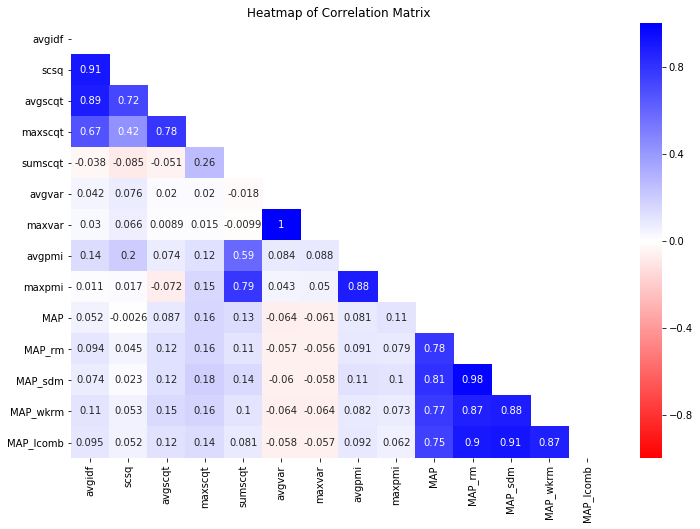

In [186]:
# Plotting correlation matrix 
import matplotlib.pyplot as plt
import seaborn as sns
corr = df3[['avgidf','scsq','avgscqt','maxscqt','sumscqt','avgvar','maxvar','avgpmi','maxpmi','MAP','MAP_rm','MAP_sdm',
            'MAP_wkrm','MAP_lcomb']].corr()
print(corr)
plt.rc('figure', figsize=(12,8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, cmap='bwr_r', vmin=-1, vmax=1, annot=True, mask=mask)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
#Printing Correlation of Pre-retrieval metrices with MAP
print("Corr avgIDF and MAP : ", numpy.corrcoef(df2['avgidf'], dfmap['MAP'])[0, 1])
print("Corr SCS(Q) and MAP : ",numpy.corrcoef(df2['scsq'], dfmap['MAP'])[0, 1])
print("Corr MaxSCQ and MAP : ",numpy.corrcoef(df2['maxscqt'], dfmap['MAP'])[0, 1])
print("Corr maxVAR and MAP : ",numpy.corrcoef(df2['maxvar'], dfmap['MAP'])[0, 1])
print("Corr avgPMI and MAP : ",numpy.corrcoef(df2['avgpmi'], dfmap['MAP'])[0, 1])
print("Corr avgIDF and SCS(Q) : ",numpy.corrcoef(df2['avgidf'], df2['scsq'])[0, 1])

In [187]:
df3[df3['MAP']==0]
#df3

,QueryNo,Query,avgidf,scsq,maxscqt,sumscqt,avgscqt,maxvar,avgvar,avgpmi,maxpmi,MAP,MAP_rm,MAP_sdm,MAP_wkrm,MAP_lcomb
18,19,the current,0.592487,6.566472,19.172645,20.074455,10.037227,7.101239e-07,3.615311e-07,0.035622,0.035622,0.0,0.0000,0.0000,0.0000,0.0000
19,20,defender,6.327310,14.125827,84.357699,84.357699,84.357699,7.115473e-05,7.115473e-05,0.000000,0.000000,0.0,0.0000,0.0000,0.0000,0.0000
65,66,income tax return online,2.594823,9.225700,56.228110,168.663514,42.165879,4.430102e-05,2.764550e-05,0.789931,2.226860,0.0,0.0010,0.0012,0.0009,0.0012
69,70,to be or not to be that is the question,0.523049,4.250850,44.731732,89.633040,8.963304,6.094858e-06,7.082571e-07,0.123729,0.437272,0.0,0.0000,0.0000,0.0000,0.0000
82,83,memory,3.762423,9.471868,67.671982,67.671982,67.671982,3.733764e-05,3.733764e-05,0.000000,0.000000,0.0,0.0000,0.0000,0.0000,0.0000
103,106,universal animal cuts reviews,3.704089,11.637130,57.721739,202.427869,50.606967,6.139590e-05,2.913575e-05,0.834680,1.538910,0.0,0.0000,0.0000,0.0000,0.0000
109,112,kenmore gas water heater,5.001674,11.874238,86.507522,249.044320,62.261080,3.580061e-04,1.829531e-04,2.467795,5.278345,0.0,0.0000,0.0000,0.0000,0.0000
110,113,hp mini 2140,5.822016,13.861608,76.346959,204.004386,68.001462,7.028754e-05,4.758649e-05,4.275733,5.003156,0.0,0.0000,0.0000,0.0000,0.0000
112,115,pacific northwest laboratory,3.512002,11.849037,54.011457,147.431479,49.143826,4.888976e-05,3.176176e-05,1.380249,1.928398,0.0,0.0000,0.0000,0.0000,0.0000
117,120,tv on computer,1.918322,8.329225,47.956740,93.704111,31.234704,4.152834e-05,1.670371e-05,0.273469,0.685772,0.0,0.0000,0.0000,0.0000,0.0000


### References:
https://github.com/bonzanini/nlp-tutorial/blob/master/notebooks/01%20recipes_exploratory_analysis.ipynb

https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/

https://gist.github.com/amontalenti/7975313